# Project 1
## Sky Cen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Store training and test data

In [2]:
training_file = "textA.txt"
test_file = "textB.txt"

def store_data(file_name):
    f = open(file_name, "r")
    text = f.read()
    data = [26 if ord(c) == 32 else ord(c) - 97 for c in list(text)]
    return data

train = np.array(store_data(training_file)[:-1])
test = np.array(store_data(test_file)[:-1])


Initialize transition and emission probability matrices

In [3]:
A = np.array([[0.49, 0.51], 
              [0.51, 0.49]])
B = np.zeros((27, 2, 2))
B[0:13] = np.array([[0.0370, 0.0371],
                   [0.0370, 0.0371]])
B[13:26] = np.array([[0.0371, 0.0370],
                    [0.0371, 0.0370]])
B[26] = np.array([[0.0367, 0.0367],
                 [0.0367, 0.0367]])

Define forward and backward algorithm

In [4]:
def forward(A, B, alpha_0, data):
    alphas = np.zeros((len(data) + 1, len(alpha_0)))
    alphas[0] = alpha_0

    qs = np.zeros((len(data) + 1))
    qs[0] = 1

    for i in range(len(data)):
        alphas[i + 1] = (np.multiply(A, B[data[i]]).T) @ alphas[i]
        qs[i + 1] = np.sum(alphas[i + 1])
        alphas[i + 1] = alphas[i + 1] / qs[i + 1]

    return alphas, qs


def backward(A, B, data, qs):
    beta_n = np.ones(A.shape[0])
    betas = np.zeros((len(data) + 1, len(beta_n)))
    betas[-1] = beta_n

    for i in range(len(data) - 1, -1, -1):
        betas[i] = ((np.multiply(A, B[data[i]])) @ betas[i + 1]) / qs[i]

    return betas


def unnormalize_alphas(alphas, qs):
    assert alphas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(alphas)

    prod_qs = 1
    for i in range(len(qs)):
        prod_qs *= qs[i]
        unnormalized_probs[i] = alphas[i] * prod_qs
    
    return unnormalized_probs


def unnormalize_betas(betas, qs):
    assert betas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(betas)
    unnormalized_probs[-1] = betas[-1]

    prod_qs = 1

    for i in range(len(qs) - 2, -1, -1):
        prod_qs *= qs[i]
        unnormalized_probs[i] = betas[i] * prod_qs
    
    return unnormalized_probs

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])
# alphas, qs = forward(A, B, np.array([1, 0, 0]), [0, 1, 1, 0])
# betas = backward(A, B, [0, 1, 1, 0], qs)

# print(alphas)
# print(betas)

# u_alphas = unnormalize_alphas(alphas, qs)
# u_betas = unnormalize_betas(betas, qs)
# marginal = np.sum(u_alphas[-1])

# print(marginal)

# assert np.isclose(np.prod(qs), marginal)
# assert np.isclose(u_betas[0][0], marginal)

# for i in range(len(alphas)):
#     assert np.isclose(np.sum(u_alphas[i] * u_betas[i]), marginal)

Define Baum-Welch algorithm

In [5]:
def baum_welch(A, B, data, iterations):
    
    log_probs = []
    for x in tqdm(range(iterations)):
        alpha_0 = np.array(A.shape[0] * [1 / A.shape[0]])
        # alpha_0 = np.array([1, 0, 0])
        alphas, qs = forward(A, B, alpha_0, data)
        betas = backward(A, B, data, qs)

        soft_counts = np.zeros((A.shape[0], A.shape[1], B.shape[0]))

        for i in range(len(data)):
            trans_emiss = np.multiply(A, B[data[i]])
            
            for j in range(trans_emiss.shape[0]):
                for k in range(trans_emiss.shape[1]):
                    soft_counts[j][k][data[i]] += alphas[i][j] * trans_emiss[j][k] * betas[i + 1][k]
        
        c_mn = np.sum(soft_counts, axis=2, keepdims=True)

        # for i in range(soft_counts.shape[0]):
        #     for j in range(soft_counts.shape[1]):
        #         for k in range(soft_counts.shape[2]):
        #             if soft_counts[i][j][k] == 0 or c_mn[i][j] == 0:
        #                 B[k][i][j] = 0
        #             else:
        #                 B[k][i][j] = soft_counts[i][j][k] / c_mn[i][j]
        B = np.where(c_mn == 0, 0, soft_counts / c_mn)
        B = np.transpose(B, (2, 0, 1))
        
        c_m = np.sum(c_mn, axis=1, keepdims=True)

        # for i in range(c_mn.shape[0]):
        #     for j in range(c_mn.shape[1]):
        #         if c_mn[i][j] == 0 or c_m[i] == 0:
        #             A[i][j] = 0
        #         else:
        #             A[i][j] = c_mn[i][j] / c_m[i]
        A = np.where(c_m == 0, 0, c_mn/ c_m)
        A = np.squeeze(A)

        log_prob = np.sum(np.log(qs))
        log_probs.append(log_prob / len(data))
    
    return A, B, log_probs

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])

# baum_welch(A, B, [0, 1, 1, 0], 1)

Train for 600 iterations

In [6]:
A, B, log_probs = baum_welch(A, B, train, 600)
assert all(x <= y for x, y in zip(log_probs, log_probs[1:]))

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [02:41<00:00,  3.71it/s]


Plot average log-probabilities

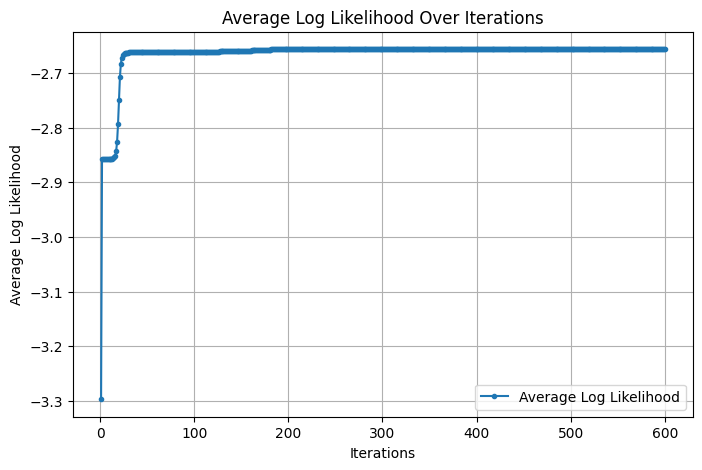

In [7]:
plt.figure(figsize=(8, 5))
iterations = range(1, len(log_probs) + 1)
plt.plot(iterations, log_probs, marker='.', linestyle='-', label="Average Log Likelihood")

plt.xlabel("Iterations")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood Over Iterations")
plt.legend()
plt.grid(True)

plt.show()

In [8]:
# print(A)
# print(B)
# print(log_probs[-1])
print(B[0])
print(B[13])

[[0.00413215 0.11619609]
 [0.01732271 0.12718325]]
[[5.26088486e-003 7.28899726e-225]
 [7.45686559e-002 1.67140909e-001]]
